In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from Data_Cleaner import data_loader_main
import pysindy as psd

In [2]:
flow_all, _, occupancy_all, flow_dt, _, occupancy_dt = data_loader_main(csv_dict='Sim_Results/Ramp_ALIANA')
control_input = pd.read_csv('Results/Meter_Rate.csv')

In [3]:
#remove initial 5 seconds
flow_all = flow_all.iloc[5:,:]
flow_dt = flow_dt.iloc[5:,:]
occupancy_all = occupancy_all.iloc[5:,:]
occupancy_dt = occupancy_dt.iloc[5:,:]
control_input = control_input.iloc[5:,:]

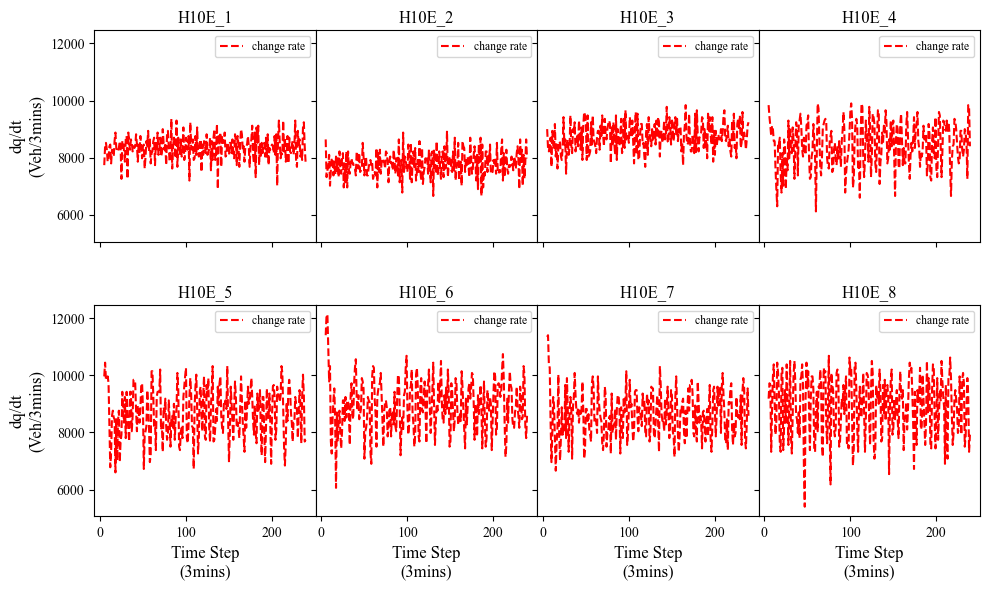

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(2):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(flow_all.iloc[:, index], "--", label = 'change rate', color = "red")
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(flow_all.columns[index], fontsize=12)

for col in range(4):
    axs[1,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(2):
    axs[row,0].set_ylabel('dq/dt\n(Veh/3mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
#fig.savefig('Figures/Flow_val.png', dpi=300)

In [6]:
train_obs = round(flow_all.shape[0]*0.7)

In [7]:
flow_train = flow_all.iloc[:train_obs,:]
flow_dt_train = flow_dt.iloc[:train_obs,:]
flow_val = flow_all.iloc[train_obs:, :]
flow_dt_val = flow_dt.iloc[train_obs:, :]
control_train = control_input.iloc[:train_obs,:]
control_val = control_input.iloc[train_obs:, :]

In [8]:
occupancy_train = occupancy_all.iloc[:train_obs,:]
occupancy_dt_train = occupancy_dt.iloc[:train_obs,:]
occupancy_val = occupancy_all.iloc[train_obs:, :]
occupancy_dt_val = occupancy_dt.iloc[train_obs:, :]

## SINDY

In [9]:
library = psd.ConcatLibrary([psd.IdentityLibrary(), psd.PolynomialLibrary(degree=2), psd.FourierLibrary(include_cos=True, include_sin=True)])

# library = psd.PolynomialLibrary(degree=2)
model = psd.SINDy(optimizer=psd.STLSQ(threshold=5e-4), feature_library=library)

In [10]:
model.fit(flow_train, u=control_train, t=1, x_dot=flow_dt_train)

C:\Users\weizi\anaconda3\envs\SUMO\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\weizi\anaconda3\envs\SUMO\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\weizi\anaconda3\envs\SUMO\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\weizi\anaconda3\envs\SUMO\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\weizi\anaconda3\envs\SUMO\lib\site-packages\sklearn\linear_model\_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
C:\Users\w

SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=<pysindy.feature_library.base.ConcatLibrary object at 0x000001D213B7ADA0>,
      feature_names=['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'u0', 'u1',
                     'u2', 'u3', 'u4', 'u5', 'u6', 'u7'],
      optimizer=STLSQ(threshold=0.0005))

In [11]:
model.print()

(x0)' = -0.078 x3 u0 + 0.078 x3 u2 + 0.068 x4 u0 + -0.068 x4 u2 + 0.001 u4^2 + -0.001 u4 u5 + -0.002 u4 u7 + 0.002 u5 u7 + 42.949 cos(1 x0) + -16.663 sin(1 x1) + -36.102 cos(1 x1) + 6.088 sin(1 x2) + 13.896 cos(1 x2) + 33.446 sin(1 x3) + -37.884 cos(1 x3) + 0.719 sin(1 x4) + 6.175 cos(1 x4) + -13.286 sin(1 x5) + -46.114 cos(1 x5) + 48.485 sin(1 x6) + -7.903 cos(1 x6) + 43.300 sin(1 x7) + -1.311 cos(1 x7) + -20.130 sin(1 u3) + -159.524 cos(1 u3) + 134.133 sin(1 u4) + 117.432 cos(1 u4) + 46.041 cos(1 u5) + -88.108 sin(1 u7) + -79.679 cos(1 u7)
(x1)' = 0.001 x0 u3 + -0.001 x0 u4 + 0.001 x0 u5 + 0.001 x1 u5 + -0.002 x2 u0 + 0.001 x2 u2 + 0.002 x3 u0 + 0.002 x3 u1 + -0.003 x3 u2 + 0.002 x4 u0 + 0.002 x4 u1 + -0.004 x4 u2 + -0.003 x5 u0 + -0.003 x5 u1 + 0.006 x5 u2 + -0.001 u0 u3 + 0.002 u0 u4 + -0.001 u1 u3 + 0.002 u1 u4 + -0.008 u1 u5 + -0.001 u2 u3 + 0.002 u2 u4 + 0.002 u3 u6 + -0.002 u4 u6 + 12.079 cos(1 x0) + 18.663 sin(1 x1) + 47.550 sin(1 x2) + -99.593 cos(1 x2) + -29.786 sin(1 x3) + 

In [12]:
# Predict derivatives using the learned model
flow_dt_pred = model.predict(flow_val, u=control_val)

In [13]:
# theta = np.array(library.transform(pd.concat([flow_val, control_val], axis=1)))
# sindy_coeff = np.transpose(model.coefficients())
# flow_dt_pred_2 = np.matmul(theta, sindy_coeff)

In [14]:
flow_dt_val = flow_dt_val.reset_index(drop=True)
occupancy_dt_val = occupancy_dt_val.reset_index(drop=True)

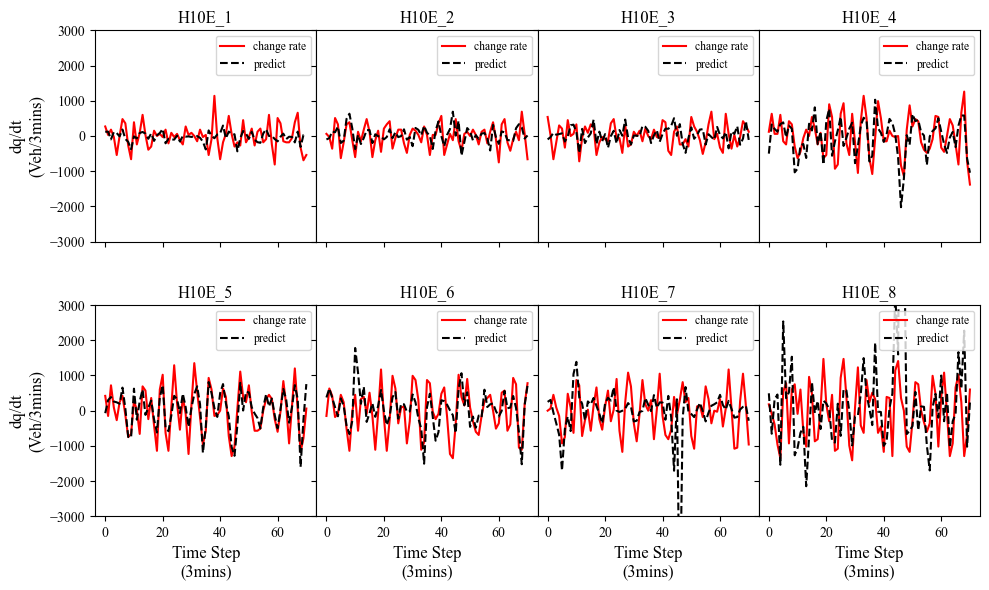

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 6), sharex=True, sharey=True)
# Plot each column in a separate subplot
for row in range(2):
    for col in range(4):
        index = row*4 + col
        axs[row, col].plot(flow_dt_val.iloc[:, index], "-", label = 'change rate', color = "red")
        axs[row, col].plot(flow_dt_pred[:, index], "--", label = 'predict', color = "black")
        axs[row, col].legend(loc='upper right', fontsize='small')
        axs[row, col].set_title(flow_all.columns[index], fontsize=12)
        axs[row, col].set_ylim([-3000, 3000])

for col in range(4):
    axs[1,col].set_xlabel('Time Step\n(3mins)', fontsize = 12)

for row in range(2):
    axs[row,0].set_ylabel('dq/dt\n(Veh/3mins)', fontsize = 12)
# Show the figure
plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0)
plt.rcParams['font.family'] = 'Times New Roman'
plt.show()
fig.savefig('Figures/SINDy_Predict.png', dpi=300)